# NLP Deep Dive with RNNs

In [101]:
from fastai.text.all import * 

In [102]:
path = untar_data(URLs.IMDB)

In [103]:
path.ls()

[Path('/home/jupyter/.fastai/data/imdb/test'), Path('/home/jupyter/.fastai/data/imdb/tmp_lm'), Path('/home/jupyter/.fastai/data/imdb/imdb.vocab'), Path('/home/jupyter/.fastai/data/imdb/train'), Path('/home/jupyter/.fastai/data/imdb/unsup'), Path('/home/jupyter/.fastai/data/imdb/models'), Path('/home/jupyter/.fastai/data/imdb/tmp_clas'), Path('/home/jupyter/.fastai/data/imdb/README')]

In [104]:
files = get_text_files(path, folders=['train', 'test', 'unsup'])

In [105]:
txt = files[0].open().read(); txt

"This movie was a modern day scarface.It had me on my toes.This movie is one of those rare epic films that makes you want a sequel.I especially liked Damian Chapa his performance deserved an academy award,which he deserved for his performance in blood in blood out.The only thing I didn't like was the behind the scenes because it didn't show the intensity that the movie had,and i would have like to have seen less narrated scenes.But the movie was great and it is in my top ten movies of all time.Plus the acting was great there wasn't a bad scene in the movie,I loved it ,Jennifer Tilly was perfect as well as all of the cast.I can't see how anyone wouldn't like this movie it was a great.Definitely a must see."

## Tokenization

In [106]:
spacy = WordTokenizer()
spacy

In [107]:
# spacy tokenizes our text with the deafult settings here, tokenizing by spaces 
toks = first(spacy([txt])); toks

['This', 'movie', 'was', 'a', 'modern', 'day', 'scarface', '.', 'It', 'had', 'me', 'on', 'my', 'toes', '.', 'This', 'movie', 'is', 'one', 'of', 'those', 'rare', 'epic', 'films', 'that', 'makes', 'you', 'want', 'a', 'sequel', '.', 'I', 'especially', 'liked', 'Damian', 'Chapa', 'his', 'performance', 'deserved', 'an', 'academy', 'award', ',', 'which', 'he', 'deserved', 'for', 'his', 'performance', 'in', 'blood', 'in', 'blood', 'out', '.', 'The', 'only', 'thing', 'I', 'did', "n't", 'like', 'was', 'the', 'behind', 'the', 'scenes', 'because', 'it', 'did', "n't", 'show', 'the', 'intensity', 'that', 'the', 'movie', 'had', ',', 'and', 'i', 'would', 'have', 'like', 'to', 'have', 'seen', 'less', 'narrated', 'scenes', '.', 'But', 'the', 'movie', 'was', 'great', 'and', 'it', 'is', 'in', 'my', 'top', 'ten', 'movies', 'of', 'all', 'time', '.', 'Plus', 'the', 'acting', 'was', 'great', 'there', 'was', "n't", 'a', 'bad', 'scene', 'in', 'the', 'movie', ',', 'I', 'loved', 'it', ',', 'Jennifer', 'Tilly', '

In [108]:
type(toks)

<class 'fastcore.foundation.L'>

In [109]:
# hmm is this fastai function really necessary? just gets a string representation to show more values... 🤷‍♀️
coll_repr(toks, 50)

"(#160) ['This','movie','was','a','modern','day','scarface','.','It','had','me','on','my','toes','.','This','movie','is','one','of','those','rare','epic','films','that','makes','you','want','a','sequel','.','I','especially','liked','Damian','Chapa','his','performance','deserved','an','academy','award',',','which','he','deserved','for','his','performance','in'...]"

In [110]:
# now lets use fastai's tokenizer 
tkn = Tokenizer(spacy)
coll_repr(tkn(txt), 50)
# we see fastai's special tokens representing "beginning of stream", "capital letter incoming!" etc. 

"(#149) ['xxbos','xxmaj','this','movie','was','a','modern','day','scarface.it','had','me','on','my','toes.this','movie','is','one','of','those','rare','epic','films','that','makes','you','want','a','sequel.i','especially','liked','xxmaj','damian','xxmaj','chapa','his','performance','deserved','an','academy','award',',','which','he','deserved','for','his','performance','in','blood','in'...]"

In [111]:
list(tkn('hello I\'m going to use an invalid english word tootyfruitcake'))

['xxbos', 'hello', 'xxmaj', 'i', "'m", 'going', 'to', 'use', 'an', 'invalid', 'english', 'word', 'tootyfruitcake']

In [112]:
coll_repr(tkn('&copy;     Fast.ai www.fast.ai/INDEX'), 31)

"(#11) ['xxbos','©','xxmaj','fast.ai','xxrep','3','w','.fast.ai','/','xxup','index']"

## Subword Tokenization

In [113]:
txts = L(f.open().read() for f in files[:2000])

In [114]:
len(txts)

2000

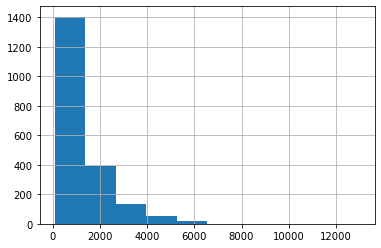

In [115]:
pd.Series([len(t) for t in txts]).hist();

In [116]:
! pip install sentencepiece!=0.1.90,!=0.1.91

In [117]:
sp = SubwordTokenizer(vocab_sz=1000)
sp

In [118]:
sp.setup(txts)
" ".join(first(sp([txt]))[:40])

'▁This ▁movie ▁was ▁a ▁mo der n ▁day ▁sc ar f a ce . I t ▁had ▁me ▁on ▁my ▁to es . This ▁movie ▁is ▁one ▁of ▁those ▁ra re ▁e p ic ▁films ▁that ▁makes ▁you ▁want ▁a'

In [119]:
def subword(sz):
  """
  tokenizes our hardcoded text with a given subword token size 
  """
  sp = SubwordTokenizer(vocab_sz=sz)
  sp.setup(txts)
  return " ".join(first(sp([txt]))[:40])

In [120]:
subword(200)

'▁ T h i s ▁movie ▁was ▁a ▁mo d er n ▁ d a y ▁ s c ar f a ce . I t ▁h a d ▁ m e ▁on ▁ m y ▁to es . T'

## Numericalization

We need to map each token to an index so we can represent words in our model 

In [121]:
tkn(txts[0])

['xxbos', 'xxmaj', 'this', 'movie', 'was', 'a', 'modern', 'day', 'scarface.it', 'had', 'me', 'on', 'my', 'toes.this', 'movie', 'is', 'one', 'of', 'those', 'rare', 'epic', 'films', 'that', 'makes', 'you', 'want', 'a', 'sequel.i', 'especially', 'liked', 'xxmaj', 'damian', 'xxmaj', 'chapa', 'his', 'performance', 'deserved', 'an', 'academy', 'award', ',', 'which', 'he', 'deserved', 'for', 'his', 'performance', 'in', 'blood', 'in', 'blood', 'out.the', 'only', 'thing', 'i', 'did', "n't", 'like', 'was', 'the', 'behind', 'the', 'scenes', 'because', 'it', 'did', "n't", 'show', 'the', 'intensity', 'that', 'the', 'movie', 'had', ',', 'and', 'i', 'would', 'have', 'like', 'to', 'have', 'seen', 'less', 'narrated', 'scenes.but', 'the', 'movie', 'was', 'great', 'and', 'it', 'is', 'in', 'my', 'top', 'ten', 'movies', 'of', 'all', 'time.plus', 'the', 'acting', 'was', 'great', 'there', 'was', "n't", 'a', 'bad', 'scene', 'in', 'the', 'movie', ',', 'i', 'loved', 'it', ',', 'jennifer', 'xxmaj', 'tilly', 'was

In [122]:
# tokenize the first 200 documents 
toks200 = txts[:200].map(tkn)
toks200[0]

['xxbos', 'xxmaj', 'this', 'movie', 'was', 'a', 'modern', 'day', 'scarface.it', 'had', 'me', 'on', 'my', 'toes.this', 'movie', 'is', 'one', 'of', 'those', 'rare', 'epic', 'films', 'that', 'makes', 'you', 'want', 'a', 'sequel.i', 'especially', 'liked', 'xxmaj', 'damian', 'xxmaj', 'chapa', 'his', 'performance', 'deserved', 'an', 'academy', 'award', ',', 'which', 'he', 'deserved', 'for', 'his', 'performance', 'in', 'blood', 'in', 'blood', 'out.the', 'only', 'thing', 'i', 'did', "n't", 'like', 'was', 'the', 'behind', 'the', 'scenes', 'because', 'it', 'did', "n't", 'show', 'the', 'intensity', 'that', 'the', 'movie', 'had', ',', 'and', 'i', 'would', 'have', 'like', 'to', 'have', 'seen', 'less', 'narrated', 'scenes.but', 'the', 'movie', 'was', 'great', 'and', 'it', 'is', 'in', 'my', 'top', 'ten', 'movies', 'of', 'all', 'time.plus', 'the', 'acting', 'was', 'great', 'there', 'was', "n't", 'a', 'bad', 'scene', 'in', 'the', 'movie', ',', 'i', 'loved', 'it', ',', 'jennifer', 'xxmaj', 'tilly', 'was

In [123]:
toks200.map(len)

[149, 463, 187, 184, 183, 281, 91, 164, 227, 513, 201, 268, 159, 197, 181, 74, 324, 372, 231, 538, 167, 1168, 771, 172, 484, 273, 336, 139, 223, 163, 254, 149, 135, 229, 303, 139, 46, 401, 290, 226, 177, 174, 233, 187, 201, 454, 226, 132, 341, 335, 359, 205, 199, 172, 196, 464, 139, 125, 509, 135, 62, 843, 243, 120, 300, 634, 332, 192, 312, 153, 707, 137, 189, 206, 156, 339, 164, 266, 289, 196, 113, 175, 185, 59, 180, 182, 155, 129, 154, 56, 259, 222, 171, 84, 814, 154, 87, 149, 88, 203, 157, 723, 69, 156, 152, 154, 306, 548, 355, 194, 179, 275, 202, 126, 287, 165, 150, 174, 188, 192, 256, 262, 195, 704, 229, 183, 101, 243, 50, 275, 281, 165, 212, 369, 313, 220, 67, 432, 187, 267, 129, 193, 57, 148, 305, 180, 401, 86, 100, 173, 129, 87, 247, 182, 203, 167, 520, 135, 184, 372, 219, 183, 312, 320, 254, 183, 143, 472, 1044, 334, 195, 483, 169, 120, 196, 216, 202, 171, 266, 255, 105, 84, 292, 139, 171, 165, 129, 528, 598, 150, 195, 201, 175, 228, 427, 188, 261, 189, 633, 159]

In [124]:
# set indices for the tokens that occur in the first 200 documents
num = Numericalize()
num.setup(toks200)
list(num.vocab)[:10]

['xxunk', 'xxpad', 'xxbos', 'xxeos', 'xxfld', 'xxrep', 'xxwrep', 'xxup', 'xxmaj', 'the']

In [125]:
toks = toks200[0] 
nums = num(toks)[:50]; nums

TensorText([   2,    8,   20,   27,   25,   13,  628,  203,    0,   86,   83,
              36,   73,    0,   27,   15,   39,   14,  150,  711, 1034,  148,
              21,  162,   33,  191,   13,    0,  265,  304,    8,    0,    8,
               0,   35,  239,  512,   49,    0,    0,   11,   89,   34,  512,
              28,   35,  239,   17, 1035,   17])

In [126]:
' '.join(num.vocab[i] for i in nums)

'xxbos xxmaj this movie was a modern day xxunk had me on my xxunk movie is one of those rare epic films that makes you want a xxunk especially liked xxmaj xxunk xxmaj xxunk his performance deserved an xxunk xxunk , which he deserved for his performance in blood in'

In [127]:
txts[0]

"This movie was a modern day scarface.It had me on my toes.This movie is one of those rare epic films that makes you want a sequel.I especially liked Damian Chapa his performance deserved an academy award,which he deserved for his performance in blood in blood out.The only thing I didn't like was the behind the scenes because it didn't show the intensity that the movie had,and i would have like to have seen less narrated scenes.But the movie was great and it is in my top ten movies of all time.Plus the acting was great there wasn't a bad scene in the movie,I loved it ,Jennifer Tilly was perfect as well as all of the cast.I can't see how anyone wouldn't like this movie it was a great.Definitely a must see."

## Put the numbers in a model 

In [128]:
nums200 = toks200.map(num)
nums200[0]

TensorText([   2,    8,   20,   27,   25,   13,  628,  203,    0,   86,   83,
              36,   73,    0,   27,   15,   39,   14,  150,  711, 1034,  148,
              21,  162,   33,  191,   13,    0,  265,  304,    8,    0,    8,
               0,   35,  239,  512,   49,    0,    0,   11,   89,   34,  512,
              28,   35,  239,   17, 1035,   17, 1035,    0,   88,  192,   19,
             110,   40,   52,   25,    9,  712,    9,  164,  127,   18,  110,
              40,   99,    9,    0,   21,    9,   27,   86,   11,   12,   19,
              78,   47,   52,   16,   47,  121,  713,    0,    0,    9,   27,
              25,   63,   12,   18,   15,   17,   73,  325,  854,  105,   14,
              46,    0,    9,  142,   25,   63,   56,   25,   40,   13,  193,
             194,   17,    9,   27,   11,   19,  251,   18,   11, 1323,    8,
               0,   25,  289,   24,   80,   24,   46,   14,    9,    0,  227,
              40,   69,  103,  209,   78,   40,   52,   20,   27

In [129]:
# language model dataloader
# LMDataLoader??

In [130]:
dl = LMDataLoader(nums200)

In [131]:
x, y = first(dl)
x.shape, y.shape

(torch.Size([64, 72]), torch.Size([64, 72]))

In [132]:
x

LMTensorText([[   2,    8,   20,  ...,    0,   21,    9],
              [   9,  721,   43,  ...,   49, 1047,   78],
              [  13,  253,    0,  ...,    0,   37,   10],
              ...,
              [   8,   63,  105,  ...,  648,    9,  701],
              [ 147,   37,   15,  ...,    8,   19,  160],
              [  27,    8,    0,  ...,   47,   70,  437]])

In [133]:
# LmTensorText -> TensorText -> TensorBase (fastai) -> Tensor (pytorch)
# TensorBase??

In [169]:
 %pprint

Pretty printing has been turned OFF


In [170]:
[num.vocab[a] for a in x[0,:]]

['xxbos', 'xxmaj', 'this', 'movie', 'was', 'a', 'modern', 'day', 'xxunk', 'had', 'me', 'on', 'my', 'xxunk', 'movie', 'is', 'one', 'of', 'those', 'rare', 'epic', 'films', 'that', 'makes', 'you', 'want', 'a', 'xxunk', 'especially', 'liked', 'xxmaj', 'xxunk', 'xxmaj', 'xxunk', 'his', 'performance', 'deserved', 'an', 'xxunk', 'xxunk', ',', 'which', 'he', 'deserved', 'for', 'his', 'performance', 'in', 'blood', 'in', 'blood', 'xxunk', 'only', 'thing', 'i', 'did', "n't", 'like', 'was', 'the', 'behind', 'the', 'scenes', 'because', 'it', 'did', "n't", 'show', 'the', 'xxunk', 'that', 'the']

In [171]:
[num.vocab[a] for a in y[0,:]]

['xxmaj', 'this', 'movie', 'was', 'a', 'modern', 'day', 'xxunk', 'had', 'me', 'on', 'my', 'xxunk', 'movie', 'is', 'one', 'of', 'those', 'rare', 'epic', 'films', 'that', 'makes', 'you', 'want', 'a', 'xxunk', 'especially', 'liked', 'xxmaj', 'xxunk', 'xxmaj', 'xxunk', 'his', 'performance', 'deserved', 'an', 'xxunk', 'xxunk', ',', 'which', 'he', 'deserved', 'for', 'his', 'performance', 'in', 'blood', 'in', 'blood', 'xxunk', 'only', 'thing', 'i', 'did', "n't", 'like', 'was', 'the', 'behind', 'the', 'scenes', 'because', 'it', 'did', "n't", 'show', 'the', 'xxunk', 'that', 'the', 'movie']

So the "label" is just the same sequence but offset by one token, i.e. containing the final "completed" token for the sequence. Interesting... 

From book RE using built-in APIs to handle numericalization and tokenization. i.e., you don't actually have to manually set up these steps, they're built into TextBLock 

*fastai handles tokenization and numericalization automatically when TextBlock is passed to DataBlock. All of the arguments that can be passed to Tokenize and Numericalize can also be passed to TextBlock. In the next chapter we'll discuss the easiest ways to run each of these steps separately, to ease debugging—but you can always just debug by running them manually on a subset of your data as shown in the previous sections. And don't forget about DataBlock's handy summary method, which is very useful for debugging data issues.*

In [172]:
# returns a list of file paths given the imdb base path 
get_imdb = partial(get_text_files, folders=['train', 'test', 'unsup'])

In [173]:
# data loaders: language model

dls_lm = DataBlock(
    blocks=TextBlock.from_folder(path, is_lm=True),
    get_items=get_imdb, 
    splitter=RandomSplitter(0.1)
).dataloaders(path, path=path, bs=128, seq_len=80)

In [174]:
dls_lm.show_batch(max_n=2)

,text,text_
0,"xxbos xxmaj films starring child actors put themselves on the back foot from the very beginning . xxmaj while there are some exceptions , the majority of kids just ca nt act and even the ones that can normally become annoying after a few minutes . xxmaj the kids in xxmaj paperhouse have managed to capture the worst of both worlds , as they 're both very annoying and they do n't have an ounce of acting ability between them","xxmaj films starring child actors put themselves on the back foot from the very beginning . xxmaj while there are some exceptions , the majority of kids just ca nt act and even the ones that can normally become annoying after a few minutes . xxmaj the kids in xxmaj paperhouse have managed to capture the worst of both worlds , as they 're both very annoying and they do n't have an ounce of acting ability between them ."
1,"necks , and the dwarf unfortunately stops xxmaj cabot from drinking some poisoned water . xxmaj dammit , xxmaj herve , could n't you just have let him die ? xxmaj we would all have thanked you , believe me ! \n\n xxmaj they get out of the desert and save a slave girl from the market . xxmaj cabot gives her a lecture about loving xxunk does this guy think he is ? xxmaj john xxmaj brown xxmaj cabot",", and the dwarf unfortunately stops xxmaj cabot from drinking some poisoned water . xxmaj dammit , xxmaj herve , could n't you just have let him die ? xxmaj we would all have thanked you , believe me ! \n\n xxmaj they get out of the desert and save a slave girl from the market . xxmaj cabot gives her a lecture about loving xxunk does this guy think he is ? xxmaj john xxmaj brown xxmaj cabot ?"


### Let's train the damn thing

In [175]:
# AWD_LSTM??

In [176]:
learn = language_model_learner(
    dls_lm, AWD_LSTM, drop_mult=0.3, 
    metrics=[accuracy, Perplexity()]).to_fp16()

In [177]:
# NOTE language_model_learner automatically freezes the parameters of the pretrained model, adding new 
# parameters for any new tokens in the vocab 

# we illustrate this below by showing that most parameters do not have gradients enabled 
for param in learn.model.parameters():
    print(param.requires_grad)

True
False
False
False
False
False
False
False
False
False
False
False
False
True


In [181]:
learn.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time


RuntimeError: Exception occured in `MixedPrecision` when calling event `after_pred`:
	CUDA out of memory. Tried to allocate 2.29 GiB (GPU 0; 14.56 GiB total capacity; 4.56 GiB already allocated; 1.35 GiB free; 4.65 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [180]:
import torch
torch.cuda.memory_summary(device=None, abbreviated=False)

In [ ]:
learn.predict("this movie was", n_words=50)

In [ ]:
learn.predict("the worst", n_words=50)

In [179]:
learn.predict("the best", n_words=50)

'the best - known European film early in The Thin White Line . Its early phases were reserved for exploitation pictures , theaters and an expensive film for the stage . The film was adjusted for idea by two actors who acted as inventor of'

In [147]:
learn.predict("", n_words=50, temperature=0.7)

'japan = a Super Smash Family Series = = a Super Smash Pack Wii Main Series ( DS ) is a pop album which takes place in the Japanese anime series Super Smash Brothers'

Damn, looks like our model is saying things about movies!

In [148]:
# learn.save('1epoch') 

In [149]:
learn = learn.load('1epoch') 

In [150]:
learn.unfreeze()

In [151]:
for param in learn.model.parameters():
    print(param.requires_grad)

True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [152]:
# learn.fit_one_cycle(10,2e-3)

In [153]:
# learn.predict("", n_words=200, temperature=0.7)

In [154]:
# learn.save('unfreeze')

In [166]:
learn = learn.load('unfreeze')

RuntimeError: Error(s) in loading state_dict for SequentialRNN:
	Missing key(s) in state_dict: "0.module.encoder.weight", "0.module.encoder_dp.emb.weight", "0.module.rnns.0.weight_hh_l0_raw", "0.module.rnns.0.module.weight_ih_l0", "0.module.rnns.0.module.bias_ih_l0", "0.module.rnns.0.module.bias_hh_l0", "0.module.rnns.1.weight_hh_l0_raw", "0.module.rnns.1.module.weight_ih_l0", "0.module.rnns.1.module.bias_ih_l0", "0.module.rnns.1.module.bias_hh_l0", "0.module.rnns.2.weight_hh_l0_raw", "0.module.rnns.2.module.weight_ih_l0", "0.module.rnns.2.module.bias_ih_l0", "0.module.rnns.2.module.bias_hh_l0", "1.layers.0.0.weight", "1.layers.0.0.bias", "1.layers.0.0.running_mean", "1.layers.0.0.running_var", "1.layers.0.2.weight", "1.layers.1.0.weight", "1.layers.1.0.bias", "1.layers.1.0.running_mean", "1.layers.1.0.running_var", "1.layers.1.2.weight". 
	Unexpected key(s) in state_dict: "0.encoder.weight", "0.encoder_dp.emb.weight", "0.rnns.0.weight_hh_l0_raw", "0.rnns.0.module.weight_ih_l0", "0.rnns.0.module.bias_ih_l0", "0.rnns.0.module.bias_hh_l0", "0.rnns.1.weight_hh_l0_raw", "0.rnns.1.module.weight_ih_l0", "0.rnns.1.module.bias_ih_l0", "0.rnns.1.module.bias_hh_l0", "0.rnns.2.weight_hh_l0_raw", "0.rnns.2.module.weight_ih_l0", "0.rnns.2.module.bias_ih_l0", "0.rnns.2.module.bias_hh_l0", "1.decoder.weight", "1.decoder.bias". 

In [156]:
learn.predict("I hated this movie because", n_words=100, temperature=0.75)

"i hated this movie because i like Doris Day and did n't want to watch her and i do n't understand why people love her . i think she was worse than Doris Day . She really had a few good scenes playing Ruth Etting . She was a good actress . The music was great , the story was pretty good . In this film , Doris played a successful woman with some financial problems but she ended up being a better woman . It was so interesting to see Ruth"

In [157]:
parent_label??

Signature: parent_label(o)
Source:   
def parent_label(o):
    "Label `item` with the parent folder name."
    return Path(o).parent.name
File:      /opt/conda/lib/python3.7/site-packages/fastai/data/transforms.py
Type:      function


In [158]:
get_text_files(path)

(#100002) [Path('/home/jupyter/.fastai/data/imdb/test/pos/11897_10.txt'),Path('/home/jupyter/.fastai/data/imdb/test/pos/2859_8.txt'),Path('/home/jupyter/.fastai/data/imdb/test/pos/7828_10.txt'),Path('/home/jupyter/.fastai/data/imdb/test/pos/9293_10.txt'),Path('/home/jupyter/.fastai/data/imdb/test/pos/4344_10.txt'),Path('/home/jupyter/.fastai/data/imdb/test/pos/7356_8.txt'),Path('/home/jupyter/.fastai/data/imdb/test/pos/12451_10.txt'),Path('/home/jupyter/.fastai/data/imdb/test/pos/9120_9.txt'),Path('/home/jupyter/.fastai/data/imdb/test/pos/11565_7.txt'),Path('/home/jupyter/.fastai/data/imdb/test/pos/4459_9.txt')...]

In [159]:
dls_clas = DataBlock(
    blocks=(TextBlock.from_folder(path, vocab=dls_lm.vocab), CategoryBlock), 
    get_y=parent_label, 
    get_items=partial(get_text_files, folders=['train','test']),
    splitter=GrandparentSplitter(valid_name='test')
).dataloaders(path,path=path,bs=128,seq_len=72)

In [160]:
dls_clas.show_batch(max_n=3)

,text,category
0,"xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules of the match , both opponents have to go through tables in order to get the win . xxmaj benoit and xxmaj guerrero heated up early on by taking turns hammering first xxmaj spike and then xxmaj bubba xxmaj ray . a xxmaj german xxunk by xxmaj benoit to xxmaj bubba took the wind out of the xxmaj dudley brother . xxmaj spike tried to help his brother , but the referee restrained him while xxmaj benoit and xxmaj guerrero",pos
1,"xxbos * * attention xxmaj spoilers * * \n\n xxmaj first of all , let me say that xxmaj rob xxmaj roy is one of the best films of the 90 's . xxmaj it was an amazing achievement for all those involved , especially the acting of xxmaj liam xxmaj neeson , xxmaj jessica xxmaj lange , xxmaj john xxmaj hurt , xxmaj brian xxmaj cox , and xxmaj tim xxmaj roth . xxmaj michael xxmaj canton xxmaj jones painted a wonderful portrait of the honor and dishonor that men can represent in themselves . xxmaj but alas … \n\n it constantly , and unfairly gets compared to "" braveheart "" . xxmaj these are two entirely different films , probably only similar in the fact that they are both about xxmaj scots in historical xxmaj scotland . xxmaj yet , this comparison frequently bothers me because it seems",pos
2,"xxbos xxmaj by now you 've probably heard a bit about the new xxmaj disney dub of xxmaj miyazaki 's classic film , xxmaj laputa : xxmaj castle xxmaj in xxmaj the xxmaj sky . xxmaj during late summer of 1998 , xxmaj disney released "" kiki 's xxmaj delivery xxmaj service "" on video which included a preview of the xxmaj laputa dub saying it was due out in "" 1 xxrep 3 9 "" . xxmaj it 's obviously way past that year now , but the dub has been finally completed . xxmaj and it 's not "" laputa : xxmaj castle xxmaj in xxmaj the xxmaj sky "" , just "" castle xxmaj in xxmaj the xxmaj sky "" for the dub , since xxmaj laputa is not such a nice word in xxmaj spanish ( even though they use the word xxmaj laputa many times",pos


reminder: toks200 is the first 200 documents in tokenized form 

In [161]:
nums_samp = toks200[:10].map(num) 

In [162]:
nums_samp.map(len)

(#10) [149,463,187,184,183,281,91,164,227,513]

Each document has a different length, which is a problem. We solve this by grouping similarly sized input together in a batch and padding the shorter documents with a special padding token 

In [163]:
learn = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.5, metrics=accuracy).to_fp16()

In [165]:
learn = learn.load('unfreeze')

RuntimeError: Error(s) in loading state_dict for SequentialRNN:
	Missing key(s) in state_dict: "0.module.encoder.weight", "0.module.encoder_dp.emb.weight", "0.module.rnns.0.weight_hh_l0_raw", "0.module.rnns.0.module.weight_ih_l0", "0.module.rnns.0.module.bias_ih_l0", "0.module.rnns.0.module.bias_hh_l0", "0.module.rnns.1.weight_hh_l0_raw", "0.module.rnns.1.module.weight_ih_l0", "0.module.rnns.1.module.bias_ih_l0", "0.module.rnns.1.module.bias_hh_l0", "0.module.rnns.2.weight_hh_l0_raw", "0.module.rnns.2.module.weight_ih_l0", "0.module.rnns.2.module.bias_ih_l0", "0.module.rnns.2.module.bias_hh_l0", "1.layers.0.0.weight", "1.layers.0.0.bias", "1.layers.0.0.running_mean", "1.layers.0.0.running_var", "1.layers.0.2.weight", "1.layers.1.0.weight", "1.layers.1.0.bias", "1.layers.1.0.running_mean", "1.layers.1.0.running_var", "1.layers.1.2.weight". 
	Unexpected key(s) in state_dict: "0.encoder.weight", "0.encoder_dp.emb.weight", "0.rnns.0.weight_hh_l0_raw", "0.rnns.0.module.weight_ih_l0", "0.rnns.0.module.bias_ih_l0", "0.rnns.0.module.bias_hh_l0", "0.rnns.1.weight_hh_l0_raw", "0.rnns.1.module.weight_ih_l0", "0.rnns.1.module.bias_ih_l0", "0.rnns.1.module.bias_hh_l0", "0.rnns.2.weight_hh_l0_raw", "0.rnns.2.module.weight_ih_l0", "0.rnns.2.module.bias_ih_l0", "0.rnns.2.module.bias_hh_l0", "1.decoder.weight", "1.decoder.bias". 

In [ ]:
dls_clas.vocab[1]

In [ ]:
len(dls_lm.vocab)